<a href="https://colab.research.google.com/github/Rachel-2000/NLP_Projects/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -d speechesdataset speechesdataset.zip

Archive:  speechesdataset.zip
replace speechesdataset/test_CLS.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import nltk
nltk.download('punkt')

# Dataset

In [ ]:
import os
from torch.utils.data import Dataset
import torch


class SpeechesClassificationDataset(Dataset):
    """
    Dataset class for text classification task.
    This the dataset you will use to train your encoder, and classifier jointly,
    end-to-end for the text classification task.

    Args:
        tokenizer (Tokenizer): The tokenizer used to encode the text.
        file_path (str): The path to the file containing the speech classification data.

    """

    def __init__(self, tokenizer, file_path):
        self.tokenizer = tokenizer
        self.samples = []

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"The file {file_path} does not exist.")

        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                label, text = line.strip().split('\t')
                if label not in ('0', '1', '2'):
                    raise ValueError(f"Invalid label: {label}")
                if len(text.strip()) == 0:
                    continue
                self.samples.append((int(label), text))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        label, text = self.samples[index]
        input_ids = torch.tensor(self.tokenizer.encode(text), dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return input_ids, label_tensor




class LanguageModelingDataset(torch.utils.data.Dataset):
    """
    Dataset class for language modeling task. This is the dataset you will use to train your encoder for the language modeling task.

    Args:
        tokenizer (Tokenizer): The tokenizer used to encode the text.
        text (str): The text data.
        block_size (int): The size of each block of text.
    """

    def __init__(self, tokenizer, text, block_size):
        self.tokenizer = tokenizer
        self.data = torch.tensor(self.tokenizer.encode(text), dtype=torch.long)
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.block_size + 1]
        x = chunk[:-1] # input
        y = chunk[1:]  # output
        return x, y

# Tokenizer

In [ ]:
from nltk.tokenize import word_tokenize
import os


class SimpleTokenizer:
    """
    A simple tokenizer class that builds a vocabulary from the given text and encodes/decodes text into indices.
    """

    def __init__(self, text):
        """Initialize the tokenizer with the initial text to build vocabulary."""
        self.vocab = set()
        self.stoi = {}
        self.itos = {}
        self.build_vocab(text)

    def build_vocab(self, text):
        """Build vocabulary from the given text."""
        tokens = word_tokenize(text)
        self.vocab = set(tokens)
        self.vocab_size = len(self.vocab) + 2
        self.stoi = {word: i for i, word in enumerate(self.vocab, start=2)}
        self.stoi['<pad>'] = 0
        self.stoi['<unk>'] = 1
        self.itos = {i: word for word, i in self.stoi.items()}

    def encode(self, text):
        """Encode the text into a list of indices."""
        tokens = word_tokenize(text)
        return [self.stoi.get(word, self.stoi['<unk>']) for word in tokens]

    def decode(self, indices):
        """Decode the list of indices back into text."""
        return ' '.join([self.itos.get(index, '<unk>') for index in indices])

# Utilities

In [ ]:
import matplotlib.pyplot as plt
import torch

class Utilities:
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model

    def sanity_check(self, sentence, block_size, status=None):
        # Encode the sentence using the tokenizer
        wordids = self.tokenizer.encode(sentence)

        # Prepare the padded input for the model
        padded_sentence = wordids[:block_size] + [0] * (block_size - len(wordids))
        input_tensor = torch.tensor(padded_sentence, dtype=torch.long).unsqueeze(0)

        # Display input tensor shape
        print("Input tensor shape:", input_tensor.shape)

        # Process the input tensor through the encoder model
        if status is None:
            _,  attn_maps = self.model(input_tensor) # Ignore the output of the model, and only get the attention maps; make sure your encoder returns the attention maps
        else:
            _, _, attn_maps = self.model(input_tensor)

        # Display the number of attention maps
        print("Number of attention maps:", len(attn_maps))
        print("Shape of attention maps:", attn_maps.shape)

        # Visualize and save the attention maps
        for j, attn_map in enumerate(attn_maps):
            att_map = attn_map.squeeze(0).detach().cpu().numpy()  # Remove batch dimension and convert to NumPy array

            # Check if the attention probabilities sum to 1 over rows
            total_prob_over_rows = torch.sum(attn_map[0], dim=1)
            if torch.any(total_prob_over_rows < 0.99) or torch.any(total_prob_over_rows > 1.01):
                print("Failed normalization test: probabilities do not sum to 1.0 over rows")
                # print("Total probability over rows:", total_prob_over_rows.numpy())
                print("Total probability over rows:", total_prob_over_rows.detach().numpy())

            # Create a heatmap of the attention map
            fig, ax = plt.subplots()
            cax = ax.imshow(att_map, cmap='hot', interpolation='nearest')
            ax.xaxis.tick_top()
            fig.colorbar(cax, ax=ax)
            plt.title(f"Attention Map {j + 1}")

            # Save the plot
            plt.savefig(f"attention_map_{j + 1}.png")

            # Show the plot
            plt.show()

# Models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
dropout = 0.2

In [ ]:
class Head(nn.Module):
    def __init__(self, block_size, emb_dim, head_dim, status):
        super().__init__()
        self.k_w = nn.Linear(emb_dim, head_dim)
        self.q_w = nn.Linear(emb_dim, head_dim)
        self.v_w = nn.Linear(emb_dim, head_dim)
        # self.k_w = nn.Linear(emb_dim, head_dim, bias=False)
        # self.q_w = nn.Linear(emb_dim, head_dim, bias=False)
        # self.v_w = nn.Linear(emb_dim, head_dim, bias=False)
        # self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        if status == "decode":
            self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        else:
            self.register_buffer("tril", None)

        # self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        key = self.k_w(x) # (B,T,H), H = head_dim
        query = self.q_w(x) # (B,T,H)
        weights = query @ key.transpose(-2,-1) * C ** (-0.5) # (B,T,T)
        # mask in training
        if self.tril is not None:
            weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf'))

        weights = F.softmax(weights, dim=-1) # softmax on last dimension, (B,T,T)
        # weights = self.dropout(weights)

        value = self.v_w(x) # (B,T,H)
        output = weights @ value # (B,T,H)

        return output, weights

In [ ]:
class MultiHead(nn.Module):
    def __init__(self, num_head, block_size, n_embd, head_size, status):
        super().__init__()
        self.multi_heads = nn.ModuleList([Head(block_size, n_embd, head_size, status) for _ in range(num_head)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x)[0] for head in self.multi_heads], dim=-1)
        attn_maps = torch.stack([head(x)[1] for head in self.multi_heads])
        out = self.proj(out)
        out = self.dropout(out)

        return out, attn_maps

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.layer(x)

In [ ]:
class Block(nn.Module):
    def __init__(self, n_head, block_size, n_embd, status="encode"):
        super().__init__()
        head_size = n_embd // n_head
        self.multi_head = MultiHead(n_head, block_size, n_embd, head_size, status)
        self.ffn = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, pre_norm=True):

        if pre_norm: # for encoder
            out, attn_maps = self.multi_head(self.ln1(x))
            x = x + out
            x = x + self.ffn(self.ln2(x))
        else: # for decoder
            out, attn_maps = self.multi_head(x)
            x = x + self.ffn(self.ln1(x + out))
            x = self.ln2(x)

        return x, attn_maps


In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, n_layer, vocab_size, n_embd, block_size, n_head, device):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # example 4 heads of 8-dimensional attention --> 32 embedding length
        # set head_size = emb size // number of heads
        # self.head = MultiHead(n_head, block_size, n_embd, n_embd // n_head)
        # self.ffn = FeedForward(n_embd)
        # self.blocks = nn.Sequential(
        #               Block(n_head, block_size, n_embd),
        #               Block(n_head, block_size, n_embd),
        #               Block(n_head, block_size, n_embd),
        #               Block(n_head, block_size, n_embd),
        #               nn.LayerNorm(n_embd)
        #               )
        # self.block1 = Block(n_head, block_size, n_embd)
        # self.block2 = Block(n_head, block_size, n_embd)
        # self.block3 = Block(n_head, block_size, n_embd)
        # self.block4 = Block(n_head, block_size, n_embd)
        # self.ln = nn.LayerNorm(n_embd)
        self.blocks = nn.ModuleList([
            Block(n_head, block_size, n_embd) for _ in range(n_layer)
        ])


    def forward(self, idx, output=None):
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T.C)
        x = token_emb + pos_emb # (B,T,C)
        attn_maps = []
        for block in self.blocks:
            x, attn_map = block(x)
            attn_maps.append(attn_map)

        attn_maps = torch.cat(attn_maps, dim=0)
        # x, attn_maps1 = self.block1(x)
        # x, attn_maps2 = self.block2(x)
        # x, attn_maps3 = self.block3(x)
        # x, attn_maps4 = self.block4(x)
        # x = self.ln(x)
        # attn_maps = torch.cat((attn_maps1, attn_maps2, attn_maps3, attn_maps4), dim=0)

        return x, attn_maps


In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, n_hidden, n_output, device="cpu"):
        super().__init__()
        self.transformer_encoder = TransformerEncoder(n_layer, vocab_size, n_embd, block_size, n_head, device)
        self.fc1 = nn.Linear(n_embd, n_hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        # x.shape = (B,T)
        x, _ = self.transformer_encoder(x) # (B,T,C)
        # x = self.transformer_encoder(x) # (B,T,C)
        # mean of the embeddings across the sequence dimension T
        x = torch.mean(x, dim=1) # (B,C)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, n_layer, vocab_size, n_embd, block_size, n_head, device="cpu"):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # self.block1 = Block(n_head, block_size, n_embd, status="decode")
        # self.block2 = Block(n_head, block_size, n_embd, status="decode")
        # self.block3 = Block(n_head, block_size, n_embd, status="decode")
        # self.block4 = Block(n_head, block_size, n_embd, status="decode")
        self.blocks = nn.ModuleList([
            Block(n_head, block_size, n_embd, status="decode") for _ in range(n_layer)
        ])
        self.ln = nn.LayerNorm(n_embd)
        self.v_back = nn.Linear(n_embd, vocab_size) # only used in decoder

    def forward(self, idx, targets=None):
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T.C)
        x = token_emb + pos_emb # (B,T,C)
        # x, _ = self.block1(x)
        # x, _ = self.block2(x)
        # x, _ = self.block3(x)
        # x, attn_maps = self.block4(x)
        # x, attn_maps1 = self.block1(x)
        # x, attn_maps2 = self.block2(x)
        # x, attn_maps3 = self.block3(x)
        # x, attn_maps4 = self.block4(x)
        x = self.ln(x)
        # attn_maps = torch.cat((attn_maps1, attn_maps2, attn_maps3, attn_maps4), dim=0)
        attn_maps = []
        for block in self.blocks:
            x, attn_map = block(x, pre_norm=False)
            attn_maps.append(attn_map)

        attn_maps = torch.cat(attn_maps, dim=0)


        logits = self.v_back(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            # logits = logits.view(B, C, T)
            # logits = logits.view(-1, C)
            logits = logits.view(B*T, C)
            # targets = targets.view(-1)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss, attn_maps

    # def generate(self, idx, max_new_tokens, block_size):
    #     # idx: (B,T)
    #     for _ in range(max_new_tokens):
    #         idx_lb = idx[:, -block_size:]
    #         logits, _ = self(idx_lb)
    #         logits = logits[:,-1,:] # (B,C)
    #         probs = F.softmax(logits, dim=-1) # shape = B
    #         idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
    #         idx = torch.cat((idx, idx_next), dim=1) # (B,T+1)

    #     return idx[:, -block_size:]

# Main program

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import os

# from tokenizer import SimpleTokenizer
# from dataset import SpeechesClassificationDataset, LanguageModelingDataset


seed = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

""" Hyperparameters to use for training to roughly match
the numbers mentioned in the assignment description """
batch_size = 16  # Number of independent sequences  we will process in parallel
block_size = 32  # Maximum context length for predictions
learning_rate = 1e-3  # Learning rate for the optimizer
n_embd = 64  # Embedding dimension
n_head = 2  # Number of attention heads
n_layer = 4  # Number of transformer layers


eval_interval = 100  # How often to evaluate train and test perplexity during training
max_iters = 500 # For language modeling, we can process all the batches for the entire dataset, but that takes a while, so we'll limit it to 500 iterations. For batch size of 16 and block size of  32, this is roughly, this is  500 * 16 * 32 = 256000 tokens, SOTA LMs are trained on trillions of tokens, so this is a very small dataset.
eval_iters = 200  # Number of iterations to evaluate perplexity on the test set


## classifier training hyperparameters. It is a simple 1 hidden layer feedforward network, with input
## size of 64, hidden size of 50 and output size of 3.

n_input = 64  # Input size for the classifier, should match the embedding size of the transformer
n_hidden = 100  # Hidden size for the classifier
n_output = 3  # Output size for the classifier, we have 3 classes
epochs_CLS = 15 # epochs for classifier training

def load_texts(directory):
    """
    This function loads all texts from the specified directory, ignoring any files with "test" in their name. The text is used for "training" the tokenizer. Since our tokenizer is simple, we don't need to do any training, but we still need to ignore the test data.
    """

    texts = []
    files = os.listdir(directory)
    for filename in files:
        if "test" in filename:  ## don't "read test files"
            continue
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            texts.append(file.read())
    return texts



def collate_batch(batch):
    """ Collate a batch of data into a single tensor with padding."""
    data, labels = zip(*batch)  # Separate the data and labels
    # Pad sequences to the fixed length
    padded_sequences = pad_sequence(data, batch_first=True, padding_value=0)
    padded_sequences = padded_sequences[:, :block_size]  # Truncate if longer
    # Add padding if shorter
    padded_sequences = torch.nn.functional.pad(padded_sequences, (0, max(0, block_size - padded_sequences.shape[1])), "constant", 0)
    labels = torch.stack(labels)
    return padded_sequences, labels

def compute_classifier_accuracy(classifier, data_loader):
    """ Compute the accuracy of the classifier on the data in data_loader."""
    classifier.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for X, Y in data_loader:
            X, Y = X.to(device), Y.to(device)
            outputs = classifier(X)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == Y).sum().item()
            total_samples += Y.size(0)
        accuracy = (100 * total_correct / total_samples)
        classifier.train()
        return accuracy


def compute_perplexity(decoderLMmodel, data_loader, eval_iters=100):
    """ Compute the perplexity of the decoderLMmodel on the data in data_loader.
    Make sure to use the cross entropy loss for the decoderLMmodel.
    """
    decoderLMmodel.eval()
    losses= []
    for X, Y in data_loader:
        X, Y = X.to(device), Y.to(device)
        _, loss, _ = decoderLMmodel(X, Y) # your model should be computing the cross entropy loss
        losses.append(loss.item())
        # total_loss += loss.item()
        if len(losses) >= eval_iters: break


    losses = torch.tensor(losses)
    mean_loss = losses.mean()
    perplexity = torch.exp(mean_loss).item()  # Calculate perplexity as exp(mean loss)

    decoderLMmodel.train()
    return perplexity

# def main():

#     print("Loading data and creating tokenizer ...")
#     texts = load_texts('speechesdataset')
#     tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data
#     print("Vocabulary size is", tokenizer.vocab_size)

#     train_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/train_CLS.tsv")
#     train_CLS_loader = DataLoader(train_CLS_dataset, batch_size=batch_size,collate_fn=collate_batch,shuffle=True)


#     inputfile = "speechesdataset/train_LM.txt"
#     with open(inputfile, 'r', encoding='utf-8') as f:
#         lmtrainText = f.read()
#     train_LM_dataset = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
#     train_LM_loader = DataLoader(train_LM_dataset, batch_size=batch_size, shuffle=True)

#     # for the classification  task, you will train for a fixed number of epochs like this:
#     # parameters: vocab_size, n_embd, block_size, n_head, n_layer, n_hidden, n_output, device
#     model = TransformerClassifier(
#                                   tokenizer.vocab_size,
#                                   n_embd, block_size,
#                                   n_head,
#                                   n_layer,
#                                   n_hidden,
#                                   n_output,
#                                   device)


#     # Define optimizer and loss function
#     cls_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     cls_loss_fn = torch.nn.CrossEntropyLoss()

#     for epoch in range(epochs_CLS):
#         for xb, yb in train_CLS_loader:
#             xb, yb = xb.to(device), yb.to(device)
#             # CLS training code here
#             cls_optimizer.zero_grad()
#             outputs = model(xb)

#             # loss
#             loss = cls_loss_fn(outputs, yb)

#             # back propagation
#             loss.backward()
#             cls_optimizer.step()

    ######### evaluate accuracy of classifier on test dataset
    # test_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/test_CLS.tsv")
    # test_CLS_loader = DataLoader(test_CLS_dataset, batch_size=batch_size,collate_fn=collate_batch,shuffle=True)

    # accuracy = compute_classifier_accuracy(model, test_CLS_loader)
    # print(f"Classifier training accuracy: {accuracy}%")


    # for the language modeling task, you will iterate over the training data for a fixed number of iterations like this:
    # for i, (xb, yb) in enumerate(train_LM_loader):
    #     if i >= max_iters:
    #         break
    #     xb, yb = xb.to(device), yb.to(device)
        # LM training code here





# if __name__ == "__main__":
#     main()


# PART 1: Encoder Trained With Classifier

In [ ]:
print("Loading data and creating tokenizer ...")
texts = load_texts('speechesdataset')
tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data
print("Vocabulary size is", tokenizer.vocab_size)

train_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/train_CLS.tsv")
train_CLS_loader = DataLoader(train_CLS_dataset, batch_size=batch_size,collate_fn=collate_batch,shuffle=True)


inputfile = "speechesdataset/train_LM.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtrainText = f.read()
train_LM_dataset = LanguageModelingDataset(tokenizer, lmtrainText,  block_size)
train_LM_loader = DataLoader(train_LM_dataset, batch_size=batch_size, shuffle=True)

Loading data and creating tokenizer ...
Vocabulary size is 5755


In [ ]:
# for the classification  task, you will train for a fixed number of epochs like this:
# parameters: vocab_size, n_embd, block_size, n_head, n_layer, n_hidden, n_output, device
model = TransformerClassifier(
                              tokenizer.vocab_size,
                              n_embd,
                              block_size,
                              n_head,
                              n_layer,
                              n_hidden,
                              n_output,
                              device,
                              )

# Define optimizer and loss function
cls_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
cls_loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(epochs_CLS):
    total_loss = 0.0
    for xb, yb in train_CLS_loader:
        xb, yb = xb.to(device), yb.to(device)
        # CLS training code here
        cls_optimizer.zero_grad()
        outputs = model(xb)

        # loss
        loss = cls_loss_fn(outputs, yb)

        # back propagation
        loss.backward()
        cls_optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_CLS_loader)
    print(f"Epoch {epoch+1}/{epochs_CLS}, Train Loss: {avg_loss:.4f}")

Epoch 1/15, Train Loss: 1.0799
Epoch 2/15, Train Loss: 1.0399
Epoch 3/15, Train Loss: 0.9682
Epoch 4/15, Train Loss: 0.8765
Epoch 5/15, Train Loss: 0.7822
Epoch 6/15, Train Loss: 0.6388
Epoch 7/15, Train Loss: 0.5010
Epoch 8/15, Train Loss: 0.3554
Epoch 9/15, Train Loss: 0.3031
Epoch 10/15, Train Loss: 0.2175
Epoch 11/15, Train Loss: 0.1393
Epoch 12/15, Train Loss: 0.1119
Epoch 13/15, Train Loss: 0.0730
Epoch 14/15, Train Loss: 0.0732
Epoch 15/15, Train Loss: 0.0713


In [ ]:
######### evaluate accuracy of classifier on test dataset
test_CLS_dataset = SpeechesClassificationDataset(tokenizer, "speechesdataset/test_CLS.tsv")
test_CLS_loader = DataLoader(test_CLS_dataset, batch_size=batch_size,collate_fn=collate_batch,shuffle=True)

accuracy = compute_classifier_accuracy(model, test_CLS_loader)
print(f"Classifier training accuracy: {accuracy}%")

Classifier training accuracy: 86.0%


Input tensor shape: torch.Size([1, 32])
Number of attention maps: 8
Shape of attention maps: torch.Size([8, 1, 32, 32])


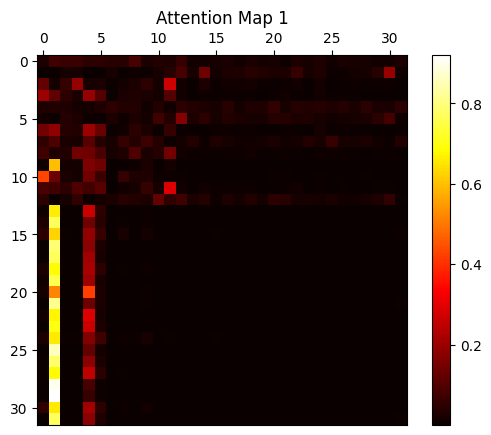

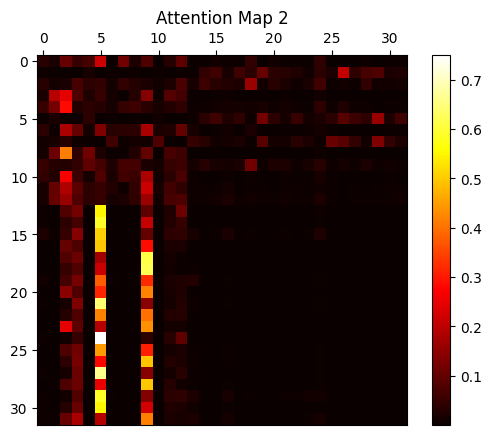

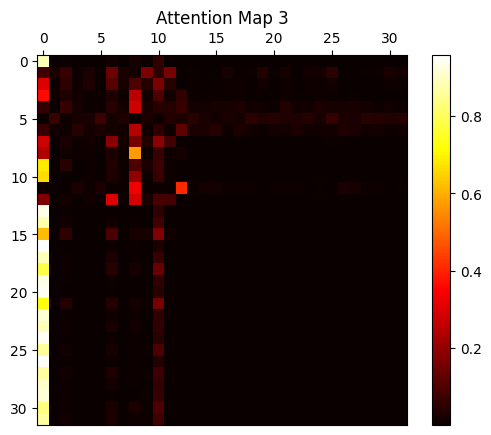

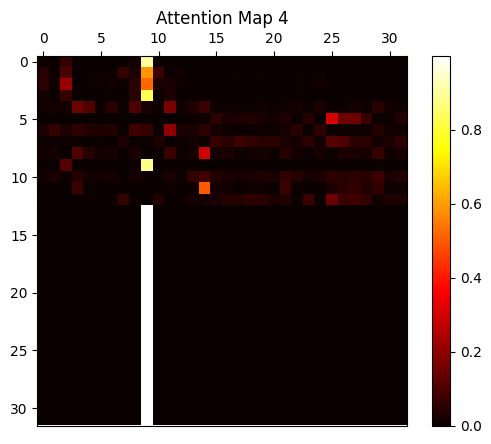

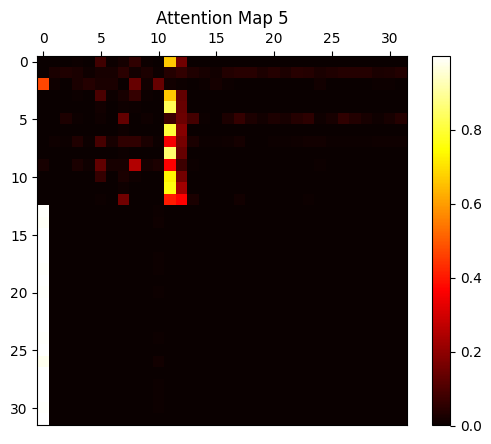

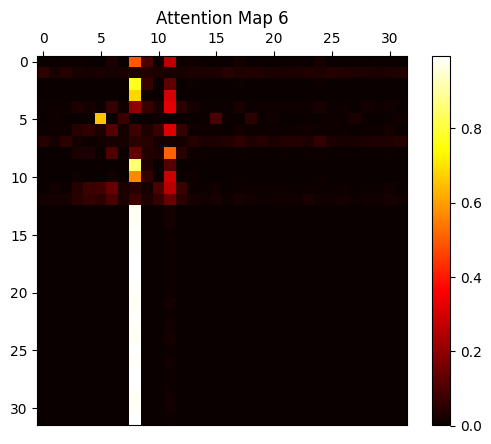

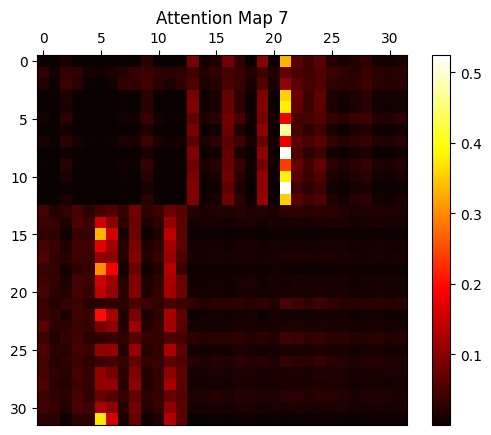

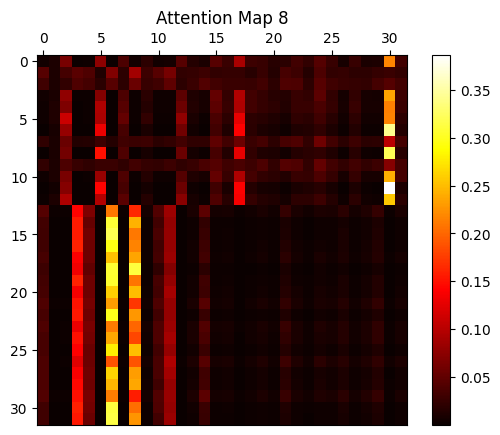

In [ ]:
utility = Utilities(tokenizer, model.transformer_encoder)
# utility.sanity_check("Fortune knocks once at everyone's door", block_size)
utility.sanity_check("And despite the costs involved, America's commitment will not weaken.", block_size)

# PART 2: Pretraining Decoder Language Model

In [ ]:
# for the language modeling task, you will iterate over the training data for a fixed number of iterations like this:
decoder = TransformerDecoder(
                            n_layer,
                            tokenizer.vocab_size,
                            n_embd,
                            block_size,
                            n_head,
                            device)

lm_optimizer = torch.optim.AdamW(decoder.parameters(), lr=1e-3)
# lm_loss_fn = torch.nn.CrossEntropyLoss()
total_loss = 0.0
max_iters = 500
for i, (xb, yb) in enumerate(train_LM_loader):
    if i >= max_iters:
        break
    xb, yb = xb.to(device), yb.to(device)

    # LM training code here
    lm_optimizer.zero_grad()
    # logits, _ = decoder(xb)  # Compute logits
    _, loss, _ = decoder(xb, yb)
    # loss = lm_loss_fn(logits.view(-1, tokenizer.vocab_size), yb.view(-1))  # Compute loss
    loss.backward()  # Backpropagation
    lm_optimizer.step()  # Update weights

    total_loss += loss.item()

    if (i+1) % 100 == 0:
        avg_loss = total_loss / (i+1)
        perplexity = compute_perplexity(decoder, train_LM_loader)
        print(f"Iters {i+1}/{max_iters}, Train Loss: {avg_loss:.4f}, Decoder perplexity: {perplexity}")

Iters 100/500, Train Loss: 6.8824, Decoder perplexity: 512.2928466796875
Iters 200/500, Train Loss: 6.4787, Decoder perplexity: 359.4458312988281
Iters 300/500, Train Loss: 6.2313, Decoder perplexity: 257.6733093261719
Iters 500/500, Train Loss: 5.8802, Decoder perplexity: 157.73350524902344


In [ ]:
inputfile = "speechesdataset/test_LM_obama.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtestText = f.read()
test_LM_dataset = LanguageModelingDataset(tokenizer, lmtestText,  block_size)
test_LM_loader = DataLoader(test_LM_dataset, batch_size=batch_size, shuffle=True)
perplexity = compute_perplexity(decoder, test_LM_loader)
print(f"Decoder perplexity: {perplexity}")

Decoder perplexity: 360.4278869628906


In [ ]:
inputfile = "speechesdataset/test_LM_hbush.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtestText = f.read()
test_LM_dataset = LanguageModelingDataset(tokenizer, lmtestText,  block_size)
test_LM_loader = DataLoader(test_LM_dataset, batch_size=batch_size, shuffle=True)
perplexity = compute_perplexity(decoder, test_LM_loader)
print(f"Decoder perplexity: {perplexity}")

Decoder perplexity: 409.0628356933594


In [ ]:
inputfile = "speechesdataset/test_LM_wbush.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtestText = f.read()
test_LM_dataset = LanguageModelingDataset(tokenizer, lmtestText,  block_size)
test_LM_loader = DataLoader(test_LM_dataset, batch_size=batch_size, shuffle=True)
perplexity = compute_perplexity(decoder, test_LM_loader)
print(f"Decoder perplexity: {perplexity}")

Decoder perplexity: 476.1165771484375


Input tensor shape: torch.Size([1, 32])
Number of attention maps: 8
Shape of attention maps: torch.Size([8, 1, 32, 32])


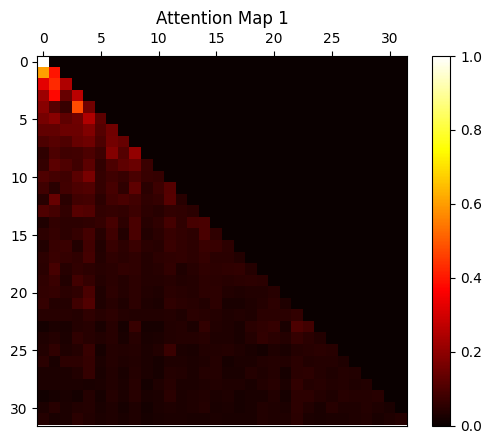

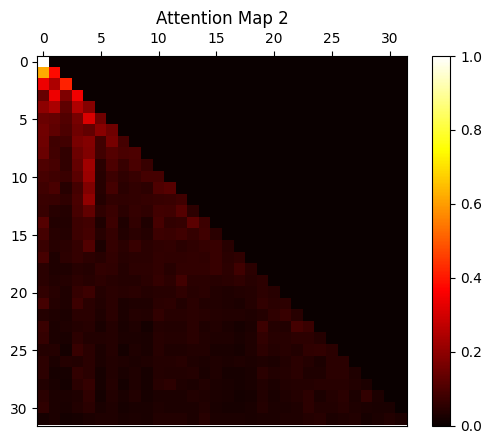

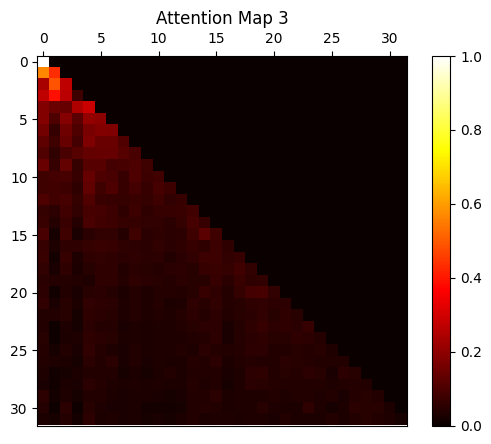

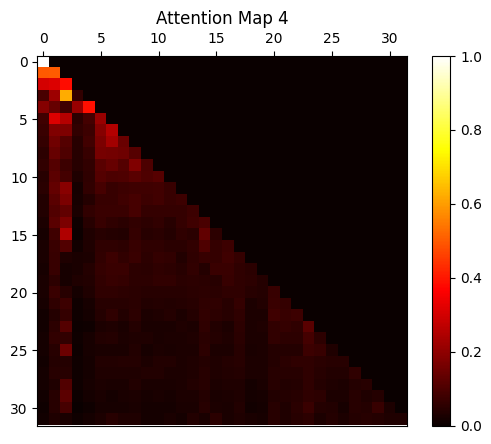

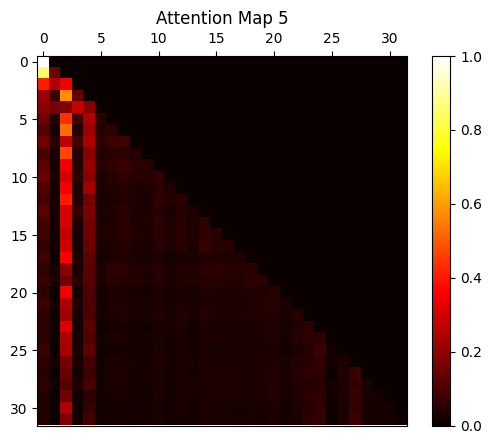

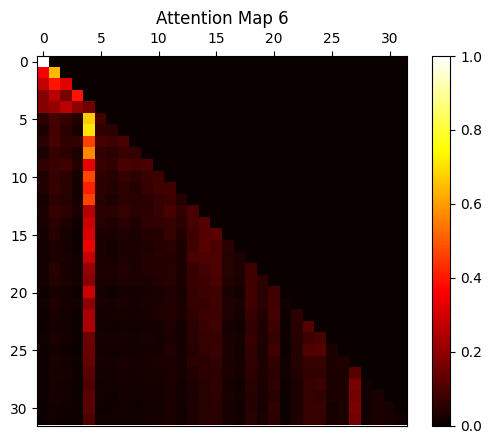

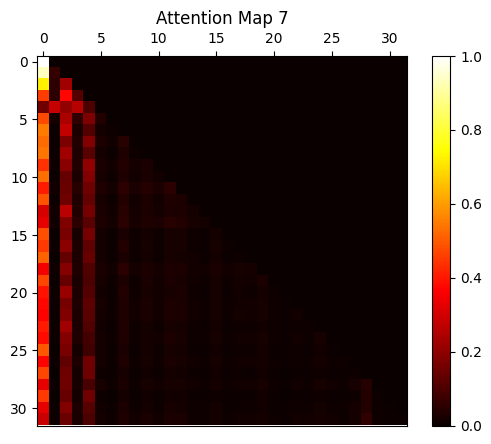

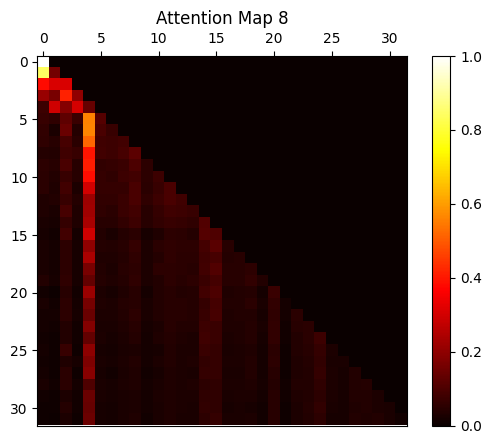

In [ ]:
utility = Utilities(tokenizer, decoder)
utility.sanity_check("I want to eat an", block_size, "decoder")

# PART 3: Exploration

### Architecture: AliBi positional encoding

In [ ]:
import numpy as np

def positional_encoding(max_seq_len, emb_dim):
    encoding = np.zeros((max_seq_len, emb_dim))
    for pos in range(max_seq_len):
        for i in range(emb_dim):
            if i % 2 == 0:
                encoding[pos, i] = np.sin(pos / 10000**(2*i / emb_dim))
            else:
                encoding[pos, i] = np.cos(pos / 10000**(2*i / emb_dim))
    return encoding

In [ ]:
def get_relative_positions(seq_len: int) -> torch.tensor:
    x = torch.arange(seq_len)[None, :]
    y = torch.arange(seq_len)[:, None]
    return x - y


def get_alibi_slope(num_heads):
    x = (2 ** 8) ** (1 / num_heads)
    return (
        torch.tensor([1 / x ** (i + 1) for i in range(num_heads)])
        .unsqueeze(-1)
        .unsqueeze(-1)
    )

In [ ]:
import math

def get_slopes(n_head):
    def get_slopes_power_of_2(n_head):
        start = (2**(-2**-(math.log2(n_head)-3)))
        ratio = start
        return [start*ratio**i for i in range(n_head)]

    if math.log2(n_head).is_integer():
        return get_slopes_power_of_2(n_head)
    else:
        closest_power_of_2 = 2**math.floor(math.log2(n_head))
        return get_slopes_power_of_2(closest_power_of_2) + get_slopes(2*closest_power_of_2)[0::2][:n_head-closest_power_of_2]

In [ ]:
def position_encoding(
    seq_len: int, dim_model: int, device: torch.device = torch.device("cpu")):
    pos = torch.arange(seq_len, dtype=torch.float, device=device).reshape(1, -1, 1)
    dim = torch.arange(dim_model, dtype=torch.float, device=device).reshape(1, 1, -1)
    phase = pos / (1e4 ** (dim / dim_model))

    return torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, n_layer, vocab_size, n_embd, block_size, n_head, device="cpu", position="default"):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        if position == "default":
            self.position_embedding_table = nn.Embedding(block_size, n_embd)
        else:
            self.position_embedding_table = None

        # self.position_embedding_table = AlibiPositionalEncoding(block_size, n_embd)
        self.blocks = nn.ModuleList([
            Block(n_head, block_size, n_embd, status="decode") for _ in range(n_layer)
        ])
        self.v_back = nn.Linear(n_embd, vocab_size) # only used in decoder

    def forward(self, idx, targets=None):
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,C)
        if self.position_embedding_table is not None:
            pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T.C)
            # pos_emb = torch.tensor(positional_encoding(block_size, n_embd), device=device, dtype=token_emb.dtype) # (T.C)
            # pos_emb = position_encoding(T, n_embd)
            x = token_emb + pos_emb # (B,T,C)
        else:
            x = token_emb

        attn_maps = []
        for block in self.blocks:
            x, attn_map = block(x)
            attn_maps.append(attn_map)

        attn_maps = torch.cat(attn_maps, dim=0)


        logits = self.v_back(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B, C, T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss, attn_maps

In [ ]:
class Head(nn.Module):
    def __init__(self, block_size, emb_dim, head_dim, head_id, status):
        super().__init__()
        self.k_w = nn.Linear(emb_dim, head_dim)
        self.q_w = nn.Linear(emb_dim, head_dim)
        self.v_w = nn.Linear(emb_dim, head_dim)
        if status == "decode":
            self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        else:
            self.register_buffer("tril", None)

        context_position = torch.arange(block_size)[:, None]
        memory_position = torch.arange(block_size)[None, :]
        relative_position = memory_position - context_position # the triangle matrix

        n_head = emb_dim // head_dim
        relative_position = torch.abs(relative_position).unsqueeze(0).expand(n_head, -1,-1)
        # print("relative_position", relative_position.shape)

        slopes = torch.Tensor(get_slopes(n_head))*-1
        alibi = slopes.unsqueeze(1).unsqueeze(1) * relative_position
        # self.alibi = self.alibi.view(1, 1, block_size, block_size)
        alibi = alibi.view(n_head, block_size, block_size)
        self.register_buffer("alibi", alibi[head_id])
        # print("alibi shape", self.alibi.shape)

        # self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        key = self.k_w(x) # (B,T,H), H = head_dim
        query = self.q_w(x) # (B,T,H)
        weights = query @ key.transpose(-2,-1) * C ** (-0.5) # (B,T,T)

        weights += self.alibi[:T,:T].to(weights)
        # weights += self.alibi[:,:,:T,:T].to(weights)
        # attn_weights = attn_weights.view(bsz*self.num_heads, tgt_len, src_len)

        # mask in training
        if self.tril is not None:
            weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        weights = F.softmax(weights, dim=-1) # softmax on last dimension, (B,T,T)
        # weights = self.dropout(weights)

        value = self.v_w(x) # (B,T,H)
        output = weights @ value # (B,T,H)

        return output, weights

In [ ]:
class MultiHead(nn.Module):
    def __init__(self, num_head, block_size, n_embd, head_size, status):
        super().__init__()
        self.multi_heads = nn.ModuleList([Head(block_size, n_embd, head_size, head_id=i, status=status) for i in range(num_head)])
        self.proj = nn.Linear(n_embd, n_embd)
        # self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x)[0] for head in self.multi_heads], dim=-1)
        attn_maps = torch.stack([head(x)[1] for head in self.multi_heads])
        out = self.proj(out)
        # out = self.dropout(out)

        return out, attn_maps

In [ ]:
decoder = TransformerDecoder(
                            n_layer,
                            tokenizer.vocab_size,
                            n_embd,
                            block_size,
                            n_head,
                            device,
                            )

lm_optimizer = torch.optim.Adam(decoder.parameters(), lr=2e-3)
# lm_loss_fn = torch.nn.CrossEntropyLoss()
total_loss = 0.0
max_iters=500
for i, (xb, yb) in enumerate(train_LM_loader):
    if i >= max_iters:
        break
    xb, yb = xb.to(device), yb.to(device)

    # LM training code here
    lm_optimizer.zero_grad()
    # logits, _ = decoder(xb)  # Compute logits
    _, loss, _ = decoder(xb, yb)
    # loss = lm_loss_fn(logits.view(-1, tokenizer.vocab_size), yb.view(-1))  # Compute loss
    loss.backward()  # Backpropagation
    lm_optimizer.step()  # Update weights

    total_loss += loss.item()

    if (i+1) % 100 == 0:
        avg_loss = total_loss / (i+1)
        perplexity = compute_perplexity(decoder, train_LM_loader)
        print(f"Iters {i+1}/{max_iters}, Train Loss: {avg_loss:.4f}, Decoder perplexity: {perplexity}")

Iters 100/500, Train Loss: 7.7006, Decoder perplexity: 1247.327392578125
Iters 200/500, Train Loss: 7.2779, Decoder perplexity: 673.9107666015625
Iters 300/500, Train Loss: 6.9545, Decoder perplexity: 425.481201171875
Iters 400/500, Train Loss: 6.7045, Decoder perplexity: 322.1737976074219
Iters 500/500, Train Loss: 6.5126, Decoder perplexity: 259.52947998046875


### Performance Improvement

In [ ]:
class Head(nn.Module):
    def __init__(self, block_size, emb_dim, head_dim, status):
        super().__init__()
        self.k_w = nn.Linear(emb_dim, head_dim, bias=False)
        self.q_w = nn.Linear(emb_dim, head_dim, bias=False)
        self.v_w = nn.Linear(emb_dim, head_dim, bias=False)
        # self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        if status == "decode":
            self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        else:
            self.register_buffer("tril", None)

        # self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        key = self.k_w(x) # (B,T,H), H = head_dim
        query = self.q_w(x) # (B,T,H)
        weights = query @ key.transpose(-2,-1) * C ** (-0.5) # (B,T,T)
        # mask in training
        if self.tril is not None:
            weights.masked_fill(self.tril[:T,:T]==0, float('-inf'))

        weights = F.softmax(weights, dim=-1) # softmax on last dimension, (B,T,T)
        # weights = self.dropout(weights)

        value = self.v_w(x) # (B,T,H)
        output = weights @ value # (B,T,H)

        return output, weights

In [ ]:
class MultiHead(nn.Module):
    def __init__(self, num_head, block_size, n_embd, head_size, status):
        super().__init__()
        self.multi_heads = nn.ModuleList([Head(block_size, n_embd, head_size, status) for _ in range(num_head)])
        self.proj = nn.Linear(n_embd, n_embd)
        # self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x)[0] for head in self.multi_heads], dim=-1)
        attn_maps = torch.stack([head(x)[1] for head in self.multi_heads])
        out = self.proj(out)
        # out = self.dropout(out)

        return out, attn_maps

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, n_layer, vocab_size, n_embd, block_size, n_head, device="cpu"):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.ModuleList([
            Block(n_head, block_size, n_embd, status="decode") for _ in range(n_layer)
        ])
        # self.ln = nn.LayerNorm(n_embd)
        self.v_back = nn.Linear(n_embd, vocab_size) # only used in decoder

    def forward(self, idx, targets=None):
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T.C)
        x = token_emb + pos_emb # (B,T,C)
        attn_maps = []
        for block in self.blocks:
            x, attn_map = block(x)
            attn_maps.append(attn_map)

        attn_maps = torch.cat(attn_maps, dim=0)


        logits = self.v_back(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B, C, T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss, attn_maps

In [ ]:
# for the language modeling task, you will iterate over the training data for a fixed number of iterations like this:
decoder = TransformerDecoder(
                            n_layer,
                            tokenizer.vocab_size,
                            n_embd,
                            block_size,
                            n_head,
                            device)

lm_optimizer = torch.optim.AdamW(decoder.parameters(), lr=5e-3)
# lm_loss_fn = torch.nn.CrossEntropyLoss()
total_loss = 0.0
for i, (xb, yb) in enumerate(train_LM_loader):
    if i >= max_iters:
        break
    xb, yb = xb.to(device), yb.to(device)

    # LM training code here
    lm_optimizer.zero_grad()
    # logits, _ = decoder(xb)  # Compute logits
    _, loss, _ = decoder(xb, yb)
    # loss = lm_loss_fn(logits.view(-1, tokenizer.vocab_size), yb.view(-1))  # Compute loss
    loss.backward()  # Backpropagation
    lm_optimizer.step()  # Update weights

    total_loss += loss.item()

    if (i+1) % 100 == 0:
        avg_loss = total_loss / (i+1)
        perplexity = compute_perplexity(decoder, train_LM_loader)
        print(f"Iters {i+1}/{max_iters}, Train Loss: {avg_loss:.4f}, Decoder perplexity: {perplexity}")


Iters 100/500, Train Loss: 7.3951, Decoder perplexity: 884.3163452148438
Iters 200/500, Train Loss: 6.9196, Decoder perplexity: 424.49713134765625
Iters 300/500, Train Loss: 6.5817, Decoder perplexity: 287.6689758300781
Iters 500/500, Train Loss: 6.1691, Decoder perplexity: 197.41268920898438


In [ ]:
inputfile = "speechesdataset/test_LM_obama.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtestText = f.read()
test_LM_dataset = LanguageModelingDataset(tokenizer, lmtestText,  block_size)
test_LM_loader = DataLoader(test_LM_dataset, batch_size=batch_size, shuffle=True)
perplexity = compute_perplexity(decoder, test_LM_loader)
print(f"Decoder perplexity: {perplexity}")

Decoder perplexity: 225.30105590820312


In [ ]:
inputfile = "speechesdataset/test_LM_hbush.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtestText = f.read()
test_LM_dataset = LanguageModelingDataset(tokenizer, lmtestText,  block_size)
test_LM_loader = DataLoader(test_LM_dataset, batch_size=batch_size, shuffle=True)
perplexity = compute_perplexity(decoder, test_LM_loader)
print(f"Decoder perplexity: {perplexity}")

Decoder perplexity: 232.54989624023438


In [ ]:
inputfile = "speechesdataset/test_LM_wbush.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtestText = f.read()
test_LM_dataset = LanguageModelingDataset(tokenizer, lmtestText,  block_size)
test_LM_loader = DataLoader(test_LM_dataset, batch_size=batch_size, shuffle=True)
perplexity = compute_perplexity(decoder, test_LM_loader)
print(f"Decoder perplexity: {perplexity}")

Decoder perplexity: 254.0797576904297


### Relative Position

In [ ]:
class RelativePosition(nn.Module):

    def __init__(self, num_units, max_relative_position):
        super().__init__()
        self.num_units = num_units
        self.max_relative_position = max_relative_position
        self.embeddings_table = nn.Parameter(torch.Tensor(max_relative_position * 2 + 1, num_units))
        nn.init.xavier_uniform_(self.embeddings_table)

    def forward(self, length_q, length_k):
        range_vec_q = torch.arange(length_q)
        range_vec_k = torch.arange(length_k)
        distance_mat = range_vec_k[None, :] - range_vec_q[:, None] # traingle matrix for relative position
        distance_mat_clipped = torch.clamp(distance_mat, -self.max_relative_position, self.max_relative_position)
        final_mat = distance_mat_clipped + self.max_relative_position
        final_mat = torch.LongTensor(final_mat)
        embeddings = self.embeddings_table[final_mat]

        return embeddings

In [ ]:
class Head(nn.Module):
    def __init__(self, block_size, emb_dim, head_dim, status):
        super().__init__()
        self.k_w = nn.Linear(emb_dim, head_dim)
        self.q_w = nn.Linear(emb_dim, head_dim)
        self.v_w = nn.Linear(emb_dim, head_dim)

        self.relative_position_k = RelativePosition(head_dim, 32)
        self.relative_position_v = RelativePosition(head_dim, 32)

        if status == "decode":
            self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        else:
            self.register_buffer("tril", None)

        # self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        key = self.k_w(x) # (B,T,H), H = head_dim，32
        query = self.q_w(x) # (B,T,H)

        _, _, H = key.shape


        r_k = self.relative_position_k(T, T) # (T, T, H)
        r_q = query.permute(1, 0, 2).contiguous().view(T, B, H)


        # print("r_k shape:", r_k.shape)

        weights = query @ key.transpose(-2,-1) # (B,T,T)
        # weights_2 = query @ r_k.transpose(-2,-1)
        weights_2 = torch.matmul(r_q, r_k.transpose(1, 2)).transpose(0, 1) # (T, B, T) --> (B, T, T)
        weights = weights + weights_2
        weights = weights * C ** (-0.5)
        # mask in training
        if self.tril is not None:
            weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))

        weights = F.softmax(weights, dim=-1) # softmax on last dimension, (B,T,T)
        # weights = self.dropout(weights)

        value = self.v_w(x) # (B,T,H)

        r_v = self.relative_position_v(T, T) # (T, T, T)
        w2 = weights.permute(1, 0, 2).contiguous().view(T, B, T)

        # value_2 = weights @ r_v
        value_2 = torch.matmul(w2, r_v).transpose(0, 1).view(B, T, H)

        # print("r_v shape:", r_v.shape)
        output = weights @ value # (B,T,H)
        output = output + value_2

        return output, weights

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, n_layer, vocab_size, n_embd, block_size, n_head, device="cpu"):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.ModuleList([
            Block(n_head, block_size, n_embd, status="decode") for _ in range(n_layer)
        ])
        # self.ln = nn.LayerNorm(n_embd)
        self.v_back = nn.Linear(n_embd, vocab_size) # only used in decoder

    def forward(self, idx, targets=None):
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx) # (B,T,C)
        # pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T.C)
        x = token_emb  # (B,T,C)
        attn_maps = []
        for block in self.blocks:
            x, attn_map = block(x, pre_norm=False)
            attn_maps.append(attn_map)

        attn_maps = torch.cat(attn_maps, dim=0)


        logits = self.v_back(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            # logits = logits.view(B, C, T)
            # logits = logits.view(-1, C)
            logits = logits.view(B*T, C)
            # targets = targets.view(-1)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss, attn_maps


In [ ]:
# for the language modeling task, you will iterate over the training data for a fixed number of iterations like this:
decoder = TransformerDecoder(
                            n_layer,
                            tokenizer.vocab_size,
                            n_embd,
                            block_size,
                            n_head,
                            device)

lm_optimizer = torch.optim.AdamW(decoder.parameters(), lr=1e-3)
# lm_loss_fn = torch.nn.CrossEntropyLoss()
total_loss = 0.0
max_iters = 500
for i, (xb, yb) in enumerate(train_LM_loader):
    if i >= max_iters:
        break
    xb, yb = xb.to(device), yb.to(device)

    # LM training code here
    lm_optimizer.zero_grad()
    # logits, _ = decoder(xb)  # Compute logits
    _, loss, _ = decoder(xb, yb)
    # loss = lm_loss_fn(logits.view(-1, tokenizer.vocab_size), yb.view(-1))  # Compute loss
    loss.backward()  # Backpropagation
    lm_optimizer.step()  # Update weights

    total_loss += loss.item()

    if (i+1) % 100 == 0:
        avg_loss = total_loss / (i+1)
        perplexity = compute_perplexity(decoder, train_LM_loader)
        print(f"Iters {i+1}/{max_iters}, Train Loss: {avg_loss:.4f}, Decoder perplexity: {perplexity}")

Iters 100/500, Train Loss: 6.7977, Decoder perplexity: 456.7764587402344
Iters 200/500, Train Loss: 6.3477, Decoder perplexity: 276.9987487792969
Iters 300/500, Train Loss: 6.0519, Decoder perplexity: 192.58941650390625
Iters 400/500, Train Loss: 5.8220, Decoder perplexity: 131.6434783935547
Iters 500/500, Train Loss: 5.6293, Decoder perplexity: 102.30365753173828


In [ ]:
inputfile = "speechesdataset/test_LM_obama.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtestText = f.read()
test_LM_dataset = LanguageModelingDataset(tokenizer, lmtestText,  block_size)
test_LM_loader = DataLoader(test_LM_dataset, batch_size=batch_size, shuffle=True)
perplexity = compute_perplexity(decoder, test_LM_loader)
print(f"Decoder perplexity: {perplexity}")

Decoder perplexity: 319.3480529785156


In [ ]:
inputfile = "speechesdataset/test_LM_hbush.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtestText = f.read()
test_LM_dataset = LanguageModelingDataset(tokenizer, lmtestText,  block_size)
test_LM_loader = DataLoader(test_LM_dataset, batch_size=batch_size, shuffle=True)
perplexity = compute_perplexity(decoder, test_LM_loader)
print(f"Decoder perplexity: {perplexity}")

Decoder perplexity: 363.6004943847656


In [ ]:
inputfile = "speechesdataset/test_LM_wbush.txt"
with open(inputfile, 'r', encoding='utf-8') as f:
    lmtestText = f.read()
test_LM_dataset = LanguageModelingDataset(tokenizer, lmtestText,  block_size)
test_LM_loader = DataLoader(test_LM_dataset, batch_size=batch_size, shuffle=True)
perplexity = compute_perplexity(decoder, test_LM_loader)
print(f"Decoder perplexity: {perplexity}")

Decoder perplexity: 424.76947021484375


# Statistic

In [ ]:
import re

def count_distinct_words(file_path):
    with open(file_path, 'r') as file:
        text = file.read().lower()  # Convert text to lowercase to ensure case-insensitivity

    # Use regular expressions to find all words
    words = re.findall(r'\b\w+\b', text)

    # Create a set to store distinct words
    distinct_words = set(words)

    # Calculate the number of distinct words
    number_of_distinct_words = len(distinct_words)

    return number_of_distinct_words


In [ ]:
def count_unseen_words(file_path: str, tokenizer) -> int:
    with open(file_path, 'r') as file:
        text = file.read().lower()

    # Use regular expressions to find all words
    words = re.findall(r'\b\w+\b', text)

    # Create a set of words in the text
    words_in_text = set(words)

    # Create a set of words known to the tokenizer (excluding '<unk>')
    known_words = set(tokenizer.stoi.keys()) - {'<unk>'}

    # Find unseen words by checking which words are not in the vocabulary
    unseen_words = words_in_text - known_words

    # Return the number of unseen words
    return len(unseen_words), unseen_words

In [ ]:
# Example usage
file_path = 'speechesdataset/test_LM_obama.txt'
distinct_word_count = count_distinct_words(file_path)
n_unseen, _ = count_unseen_words(file_path, tokenizer)
print(f"The number of distinct words is {distinct_word_count}, unseen words {n_unseen}.")

The number of distinct words is 1430, unseen words 202.


In [ ]:
file_path = 'speechesdataset/test_LM_hbush.txt'
distinct_word_count = count_distinct_words(file_path)
n_unseen, _ = count_unseen_words(file_path, tokenizer)
print(f"The number of distinct words is {distinct_word_count}, unseen words {n_unseen}.")

The number of distinct words is 1312, unseen words 198.


In [ ]:
file_path = 'speechesdataset/test_LM_wbush.txt'
distinct_word_count = count_distinct_words(file_path)
n_unseen, _ = count_unseen_words(file_path, tokenizer)
print(f"The number of distinct words is {distinct_word_count}, unseen words {n_unseen}.")

The number of distinct words is 1330, unseen words 174.
